deepface是一个Python轻量级人脸识别和人脸属性分析（年龄、性别、情感和种族）框架，提供非常简单的接口就可以实现各种人脸识别算法的应用。deepface官方仓库为[deepface](https://github.com/serengil/deepface)。deepface提供了多种模型，模型下载地址为[deepface_models](https://github.com/serengil/deepface_models/releases)。

安装方式： pip install deepface -i https://pypi.tuna.tsinghua.edu.cn/simple

deepface主要提供以下人脸识别算法，具体对应接口为：

+ DeepFace.verify：人脸验证
+ DeepFace.find：人脸识别
+ DeepFace.analyze：人脸属性分析
+ DeepFace.detectFace：人脸检测
+ DeepFace.represent：人脸特征提取
+ DeepFace.stream：人脸实时分析

总体而言，这个项目的人脸识别模型识别效果还行，但是离工程应用还是有一定的距离，不过还是非常推荐学习该库内部代码。

某些网站会判定本文人脸图片违规，这是网站识别算法自身问题。

此外可以看一看另外一个人脸识别库，功能更加齐全：[[深度学习] Python人脸识别库face_recognition使用教程](https://blog.csdn.net/LuohenYJ/article/details/123144785)

# 0 数据准备

In [1]:
# deep库的导入就一行代码
from deepface import DeepFace
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import cv2
import numpy as np

所使用的数据集为网络明星图片，共五个明星，每个明星三张人脸，数据集的路径如下：

```
root
├── images
│   ├── baijingting
│   │   ├── 0000.jpg
│   │   ├── 0001.jpg
│   ├── jiangwei
│   │   ├── 0000.jpg
│
├── code
```

数据展示结果如下：

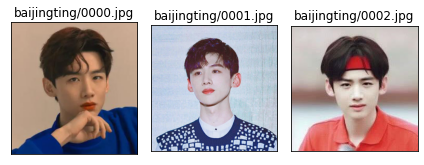

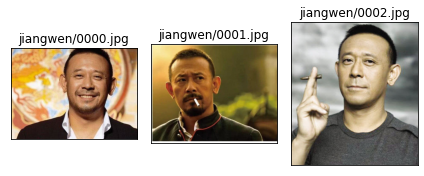

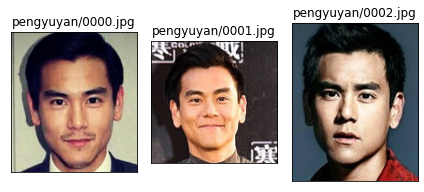

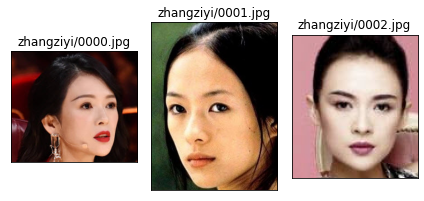

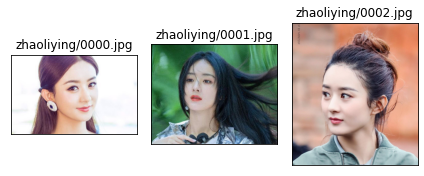

In [2]:
# --- 展示图片
def show_img(imgs: list, img_names: list) -> None:
    imgs_count = len(imgs)
    for i in range(imgs_count):
        ax = plt.subplot(1, imgs_count, i+1)
        ax.imshow(imgs[i])
        ax.set_title(img_names[i])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout(h_pad=3)
    plt.show()


img_path = "images"
for person_dir in os.listdir(img_path):
    imgs = []
    img_names = []
    for file in os.listdir(os.path.join(img_path, person_dir)):
        imgs.append(Image.open(os.path.join(img_path, person_dir, file)))
        img_names.append(person_dir + '/' + file)
    show_img(imgs, img_names)

# 1 人脸验证DeepFace.verify

此函数用于验证图像对是同一个人还是不同的人。函数接口为：

```Python
verify(img1_path, img2_path = '', model_name = 'VGG-Face', distance_metric = 'cosine', model = None, enforce_detection = True, detector_backend = 'opencv', align = True, prog_bar = True, normalization = 'base')
```

输入参数介绍：

```
img1_path：传递的图像路径、numpy数组（BGR）或based64编码图像
model_name：模型名，支持VGG-Face, Facenet, OpenFace, DeepFace, DeepID, Dlib, ArcFace，Ensemble等
distance_metric：度量标准，支持cosine, euclidean, euclidean_l2
model：构建deepface模型。每次调用verify函数都会重新建立人脸识别模型。可以选择传递预构建的人脸识别模型。如DeepFace.build_model('VGG-Face')构建模型
enforce_detection：如果在图像中检测不到任何人脸，则验证函数将返回异常。将此设置为False将不会出现此异常
detector_backend：人脸识别算法后端，支持retinaface, mtcnn, opencv, ssd，dlib
align：是否人脸对齐
prog_bar：启用或禁用进度条
normalization：人脸归一化的方式
```

输出结果介绍：

```
如果img1_path是输入一张人脸就是返回一个字典，如果输入列表则返回一个字典列表。具体参数如下：
verified：是否同一个人
distance：人脸距离，越小越相似
max_threshold_to_verify：判断为同一个人的阈值
model: 所用模型
similarity_metric: 相似性度量标准
```

各识别模型的精度如下，LFW和YTF都是小型数据集。Human-beings表示人类识别精度。

| Model | LFW Score | YTF Score |
| ---   | --- | --- |
| Facenet512 | 99.65% | - |
| SFace | 99.60% | - |
| ArcFace | 99.41% | - |
| Dlib | 99.38 % | - |
| Facenet | 99.20% | - |
| VGG-Face | 98.78% | 97.40% |
| **Human-beings** | **97.53%** | - |
| OpenFace | 93.80% | - |
| DeepID | - | 97.05% |

**demo1**

In [3]:
# 模型名
models_name = ["VGG-Face", "Facenet", "Facenet512", "OpenFace",
               "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace", 'Ensemble']

model_name = models_name[5]
result = DeepFace.verify(img1_path="images/baijingting/0001.jpg",
                         img2_path="images/pengyuyan/0001.jpg",
                         model_name=model_name)
# 展示结果，两个人不是同一个人
print(result)

1/1 [==============================] - 0s 20ms/step
{'verified': False, 'distance': 0.0751386867894902, 'threshold': 0.015, 'model': 'DeepID', 'detector_backend': 'opencv', 'similarity_metric': 'cosine'}


**demo2**

In [4]:
models_name = ["VGG-Face", "Facenet", "Facenet512", "OpenFace",
               "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace", 'Ensemble']
# 提前加载模型，避免重复加载
model_name = models_name[1]
# 创建模型
model = DeepFace.build_model(model_name)
# 列表中每一个子项表示用于对比的图像
img_paths = [["images/baijingting/0000.jpg", "images/baijingting/0001.jpg"],
             ["images/baijingting/0000.jpg", "images/zhaoliying/0001.jpg"]]
# 度量标准
metrics = ["cosine", "euclidean", "euclidean_l2"]

results = DeepFace.verify(img_paths,
                          model_name=model_name,
                          model=model,
                          distance_metric=metrics[2],
                          prog_bar=False)
# 展示结果
for result in results.items():
    print(result)

1/1 [==============================] - 0s 66ms/step
('pair_1', {'verified': True, 'distance': 0.6328494898310356, 'threshold': 0.8, 'model': 'Facenet', 'detector_backend': 'opencv', 'similarity_metric': 'euclidean_l2'})
('pair_2', {'verified': False, 'distance': 1.1700473293978308, 'threshold': 0.8, 'model': 'Facenet', 'detector_backend': 'opencv', 'similarity_metric': 'euclidean_l2'})


# 2 人脸识别DeepFace.find

此函数用于从数据集中检索当前人脸相似的图片。函数接口为：
```Python
find(img_path, db_path, model_name ='VGG-Face', distance_metric = 'cosine', model = None, enforce_detection = True, detector_backend = 'opencv', align = True, prog_bar = True, normalization = 'base', silent=False):
    
```

输入参数和verify差不多，主要多了人脸检索库路径地址：

```
db_path：检索库路径，
silent: 是否静默显示数据，
```

输出结果介绍：
```
一个包含相似图像的pandas dataframe数据体，包括图像路径和距离值，
```


In [5]:
models_name = ["VGG-Face", "Facenet", "Facenet512", "OpenFace",
               "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace", 'Ensemble']

# db_path是库文件地址
# 第一次会提取各个图像的特征，并保存到本地pkl文件以供下次直接调用
result = DeepFace.find(img_path="images/baijingting/0000.jpg",
                       db_path="images", model_name=models_name[1])

1/1 [==============================] - 0s 55ms/step
Representations stored in  images / representations_facenet.pkl  file. Please delete this file when you add new identities in your database.
1/1 [==============================] - 0s 56ms/step
find function lasts  3.254298448562622  seconds


In [6]:
# 展示结果，第一个是识别图像本身，后面两个是相似图片
print(result)

                      identity  Facenet_cosine
0  images\baijingting/0000.jpg   -2.220446e-16
1  images\baijingting/0001.jpg    2.002492e-01
2  images\baijingting/0002.jpg    2.328966e-01


# 3 人脸属性分析DeepFace.analyze

此函数用于分析当前人脸的面部属性，包括年龄，性别，面部表情（包括愤怒、恐惧、正常、悲伤、厌恶、快乐和惊讶），种族（包括亚洲人、白人、中东人、印度人、拉丁裔和黑人）。函数接口为：

```python
analyze(img_path, actions = ('emotion', 'age', 'gender', 'race') , models = None, enforce_detection = True, detector_backend = 'opencv', prog_bar = True)
```


输入参数和verify差不多，主要多了属性设置actions：

```
actions：识别属性，包括age, gender, emotion, race
```

输出结果介绍：

```
如果img_path是输入一张人脸就是返回一个字典，如果输入列表则返回一个字典列表。具体参数如下：
region：人脸坐标，wywh格式
age：年龄
gender：性别
dominant_emotion: 主导情绪，也就是情绪识别结果
emotion：各个情绪度量值，值越大表示越倾向
dominant_race：种族结果
race：各个种族度量值

```

In [7]:
# 输入检测图像，这里只识别情绪，因为其他模型实在太大了，下载下来要很久。
result = DeepFace.analyze(img_path = "images/jiangwen/0000.jpg", actions = ['emotion'])
print(result)

1/1 [==============================] - 0s 113ms/step
{'emotion': {'angry': 2.147514166495057e-06, 'disgust': 3.124029827739067e-14, 'fear': 1.990160924947304e-06, 'happy': 99.9697208404541, 'sad': 1.9864262412738753e-05, 'surprise': 0.01537421194370836, 'neutral': 0.014887277211528271}, 'dominant_emotion': 'happy', 'region': {'x': 198, 'y': 34, 'w': 185, 'h': 185}}


数据可视化看看结果

表情：happy


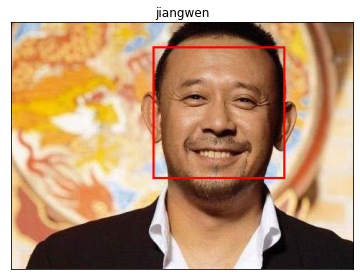

In [8]:
im = Image.open( "images/jiangwen/0000.jpg")
# 坐标位置
x,y,w,h = result['region']['x'],result['region']['y'],result['region']['w'],result['region']['h']
draw = ImageDraw.Draw(im)
# 画框
draw.rectangle((x,y,x+w,y+h), outline="red", width=3)
print("表情：{}".format(result["dominant_emotion"]))
show_img([im],["jiangwen"])

# 4 人脸检测DeepFace.detectFace

此函数用于检测人脸，如果图像中有多个人脸只会返回一个，函数接口为：
```Python
detectFace(img_path, target_size = (224, 224), detector_backend = 'opencv', enforce_detection = True, align = True)
```

输入参数和verify差不多，主要多了可以设置返回图像的尺寸的参数target_size，输出返回一张RGB的numpy数组图像

(224, 224, 3)


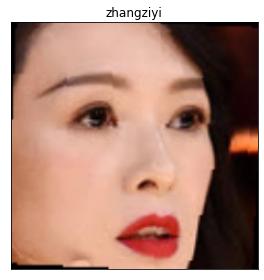

In [9]:
result = DeepFace.detectFace(img_path = "images/zhangziyi/0000.jpg",align = True)
print(result.shape)
show_img([result],["zhangziyi"])

(224, 224, 3)


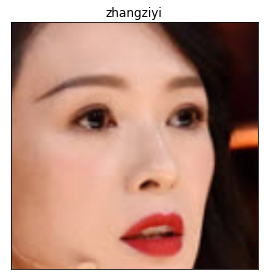

In [10]:
# 不进行人脸对齐
result = DeepFace.detectFace(img_path = "images/zhangziyi/0000.jpg",align = False)
print(result.shape)
show_img([result],["zhangziyi"])

# 5 人脸特征提取DeepFace.represent

该函数用于将面部图像表示为特征向量，函数接口为：

```Python
represent(img_path, model_name = 'VGG-Face', model = None, enforce_detection = True, detector_backend = 'opencv', align = True, normalization = 'base')
```

输入参数和verify差不多。输出返回图像特征多维向量，特征向量的维度根据模型而变化。

In [11]:
models_name = ["VGG-Face", "Facenet", "Facenet512", "OpenFace",
               "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace", 'Ensemble']


result = DeepFace.represent(img_path="images/baijingting/0000.jpg", model_name=models_name[1])
print("特征维度为：{}".format(len(result)))

1/1 [==============================] - 0s 61ms/step
特征维度为：128


当然提取特征可以自己计算距离，设置阈值。示例如下。

In [12]:
# 计算l2距离
def l2_distance(input1: np.ndarray, input2: np.ndarray) -> float:
    # 手动计算 np.sqrt(np.sum((result1- result2)**2))
    return np.linalg.norm(input1-input2)

# 计算l1距离
def l1_distance(input1: np.ndarray, input2: np.ndarray) -> float:
    # 手动计算 np.sum(abs(input1-input2))
    return np.linalg.norm(input1-input2, ord=1)

# 计算余弦距离
def IP_distance(input1: np.ndarray, input2: np.ndarray) -> float:
    return 1 - np.dot(input1, input2)/np.linalg.norm(input1)/np.linalg.norm(input2)

In [13]:
models_name = ["VGG-Face", "Facenet", "Facenet512", "OpenFace",
               "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace", 'Ensemble']

# 提前加载模型，避免重复加载
model_name = models_name[1]
# 创建模型
model = DeepFace.build_model(model_name)

# res1和res3为同一个人
res1 = DeepFace.represent(
    img_path="images/baijingting/0000.jpg", model_name=models_name[1], model=model)
res2 = DeepFace.represent(
    img_path="images/zhangziyi/0000.jpg", model_name=models_name[1], model=model)
res3 = DeepFace.represent(
    img_path="images/baijingting/0001.jpg", model_name=models_name[1], model=model)

# 转换为numpy类型
res1 = np.array(res1)
res2 = np.array(res2)
res3 = np.array(res3)

print("res1与res2的余弦距离为：{}".format(IP_distance(res1,res2)))
print("res1与res3的余弦距离为：{}".format(IP_distance(res1,res3)))
print("res1与res2的l2距离为：{}".format(l2_distance(res1,res2)))
print("res1与res3的l2距离为：{}".format(l2_distance(res1,res3)))
print("res1与res2的l1距离为：{}".format(l1_distance(res1,res2)))
print("res1与res3的l1距离为：{}".format(l1_distance(res1,res3)))

1/1 [==============================] - 0s 52ms/step
res1与res2的余弦距离为：0.6868675298615137
res1与res3的余弦距离为：0.2002492383897012
res1与res2的l2距离为：12.135816884638682
res1与res3的l2距离为：6.657409646028565
res1与res2的l1距离为：110.3180431430228
res1与res3的l1距离为：58.20380371063948


# 6 参考

+ [deepface](https://github.com/serengil/deepface)
+ [deepface_models](https://github.com/serengil/deepface_models/releases)
+ [[深度学习] Python人脸识别库face_recognition使用教程](https://blog.csdn.net/LuohenYJ/article/details/123144785)